In [1]:
import time
import queue
import pandas as pd
import threading
from typing import Union, List
from tqdm import tqdm
from pathlib import Path
import numpy as np
from datasets import Dataset
from transformers import PreTrainedTokenizerFast
from tokenizers.processors import TemplateProcessing
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)
from tokenizers.models import BPE
from statistics import mean, median
from tokenizers.pre_tokenizers import Digits, Whitespace, Sequence
import matplotlib.pyplot as plt
from Bio.Seq import translate

PathLike = Union[str, Path] 
import re
import os
import torch
from utils import any_file_fasta_reader, group_and_contextualize
import json

# from genslm.utils import read_fasta_only_seq, read_fasta, Sequence

# Assign a unique character to each codon so that we can use it as an
# input token to a BPE tokenizer. This implements a codon-pair encoding.
CODON_CHAR = {
    "TCG": "A",
    "GCA": "B",
    "CTT": "C",
    "ATT": "D",
    "TTA": "E",
    "GGG": "F",
    "CGT": "G",
    "TAA": "H",
    "AAA": "I",
    "CTC": "J",
    "AGT": "K",
    "CCA": "L",
    "TGT": "M",
    "GCC": "N",
    "GTT": "O",
    "ATA": "P",
    "TAC": "Q",
    "TTT": "R",
    "TGC": "S",
    "CAC": "T",
    "ACG": "U",
    "CCC": "V",
    "ATC": "W",
    "CAT": "X",
    "AGA": "Y",
    "GAG": "Z",
    "GTG": "a",
    "GGT": "b",
    "GCT": "c",
    "TTC": "d",
    "AAC": "e",
    "TAT": "f",
    "GTA": "g",
    "CCG": "h",
    "ACA": "i",
    "CGA": "j",
    "TAG": "k",
    "CTG": "l",
    "GGA": "m",
    "ATG": "n",
    "TCT": "o",
    "CGG": "p",
    "GAT": "q",
    "ACC": "r",
    "GAC": "s",
    "GTC": "t",
    "TGG": "u",
    "CCT": "v",
    "GAA": "w",
    "TCA": "x",
    "CAA": "y",
    "AAT": "z",
    "ACT": "0",
    "GCG": "1",
    "GGC": "2",
    "CTA": "3",
    "AAG": "4",
    "AGG": "5",
    "CAG": "6",
    "AGC": "7",
    "CGC": "8",
    "TTG": "9",
    "TCC": "!",
    "TGA": "@",
    "XXX": "*",
}


def build_tokenizer(
    corpus_iterator,
    vocab_size,
    tokenizer_type: str,
    add_bos_eos: bool = True,
    max_length: int = 1024,
    save: bool = False,
    initial_alphabet: list[str] = None,
):
    special_tokens = {
        "unk_token": "[UNK]",
        "cls_token": "[CLS]",
        "sep_token": "[SEP]",
        "pad_token": "[PAD]",
        "mask_token": "[MASK]",
        "bos_token": "[BOS]",
        "eos_token": "[EOS]",
    }

    bos_index = 5
    eos_index = 6

    # Define tokenizer
    tokenizer = Tokenizer(BPE(unk_token=special_tokens["unk_token"]))

    if tokenizer_type == "cpe_tokenizer":
        tokenizer.pre_tokenizer = Digits(individual_digits=False)

    else:
        tokenizer.pre_tokenizer = Whitespace()

    trainer = trainers.BpeTrainer(
        vocab_size=vocab_size,
        special_tokens=list(special_tokens.values()),
        # initial_alphabet=initial_alphabet
    )

    print("Training tokenizer")

    tokenizer.train_from_iterator(corpus_iterator, trainer=trainer)
    # Add post-processor
    # trim_offsets=True will ignore spaces, false will leave them in
    tokenizer.post_processor = processors.ByteLevel(trim_offsets=True)
    if add_bos_eos:
        tokenizer.post_processor = TemplateProcessing(
            single="[BOS] $A [EOS]",
            special_tokens=[("[BOS]", bos_index), ("[EOS]", eos_index)],
        )

    # Add a decoder
    tokenizer.decoder = decoders.ByteLevel()

    # save the tokenizer
    wrapped_tokenizer = PreTrainedTokenizerFast(
        tokenizer_object=tokenizer, **special_tokens
    )
    if save:
        # wrapped_tokenizer.save_pretrained(
        #     f"data/experiment_tokenizers_saved/{tokenizer_type}s/{tokenizer_type}_{tokenizer.get_vocab_size()}"
        # )
        wrapped_tokenizer.save_pretrained("cpe_tokenizer_retrained_3000")

    print(f"Returning tokenizer with vocab_size = {tokenizer.get_vocab_size()}")

    return wrapped_tokenizer


# ImportError: cannot import name 'group_and_contextualize_cpe_training' from 'utils' (/home/couchbucks/Documents/saketh/cpe/cpe/utils.py)
def group_and_contextualize_cpe_training(seq: str, k: int = 3):
    return "".join(CODON_CHAR.get(seq[i : i + k]) for i in range(0, len(seq), k))

/home/couchbucks/Documents/saketh/cpe/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

from transformers import PreTrainedTokenizerFast
from tokenizers.processors import TemplateProcessing
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)
from tokenizers.models import BPE
#from statistics import mean, median
from tokenizers.pre_tokenizers import Digits, Whitespace, Sequence
def build_tokenizer(
    corpus_iterator,
    vocab_size,
    tokenizer_type: str,
    add_bos_eos: bool = True,
    max_length: int = 1024,
    save: bool = False,
    initial_alphabet: list[str] = None,
    save_name: str = ''
):
    special_tokens = {
        "unk_token": "[UNK]",
        "cls_token": "[CLS]",
        "sep_token": "[SEP]",
        "pad_token": "[PAD]",
        "mask_token": "[MASK]",
        "bos_token": "[BOS]",
        "eos_token": "[EOS]",
    }

    bos_index = 5
    eos_index = 6

    # Define tokenizer
    tokenizer = Tokenizer(BPE(unk_token=special_tokens["unk_token"]))

    if tokenizer_type == "cpe_tokenizer":
        tokenizer.pre_tokenizer = Digits(individual_digits=False)

    else:
        tokenizer.pre_tokenizer = Whitespace()

    trainer = trainers.BpeTrainer(
        vocab_size=vocab_size,
        special_tokens=list(special_tokens.values()),
        # initial_alphabet=initial_alphabet
    )

    print("Training tokenizer")

    tokenizer.train_from_iterator(corpus_iterator, trainer=trainer)
    # Add post-processor
    # trim_offsets=True will ignore spaces, false will leave them in
    tokenizer.post_processor = processors.ByteLevel(trim_offsets=True)
    if add_bos_eos:
        tokenizer.post_processor = TemplateProcessing(
            single="[BOS] $A [EOS]",
            special_tokens=[("[BOS]", bos_index), ("[EOS]", eos_index)],
        )

    # Add a decoder
    tokenizer.decoder = decoders.ByteLevel()

    # save the tokenizer
    wrapped_tokenizer = PreTrainedTokenizerFast(
        tokenizer_object=tokenizer, **special_tokens
    )
    if save:
        # wrapped_tokenizer.save_pretrained(
        #     f"data/experiment_tokenizers_saved/{tokenizer_type}s/{tokenizer_type}_{tokenizer.get_vocab_size()}"
        # )
        wrapped_tokenizer.save_pretrained(save_name)

    print(f"Returning tokenizer with vocab_size = {tokenizer.get_vocab_size()}")

    return wrapped_tokenizer

In [3]:
def plot_vocab_lens(
    sequence_fasta_file: str, vocab_sizes: list[int], bpe_tokenizer_type: str, save_tokenizer: bool = False, save_plot_data: bool = True
):
    """_summary_

    Args:
        sequences [str]: _description_
        max_vocab_len (int): _description_
        increment (int): _description_
        bpe_tokenizer_type (str): choices: ["ape_tokenizer", "cpe_tokenizer", "npe_tokenizer"]
    """

    dna_sequences = any_file_fasta_reader(sequence_fasta_file)

    # data preprocessing dependent on tokenizer_type
    if bpe_tokenizer_type == "ape_tokenizer":
        sequences = [translate(seq.upper()) for seq in dna_sequences]
        # initial_alphabet = ['R', 'H', 'K', 'D', 'E', 'S', 'T', 'N', 'Q', 'A', 'V', 'I', 'L', 'M', 'F', 'Y', 'W', 'C', 'G', 'P', '_', 'X']

    elif bpe_tokenizer_type == "cpe_tokenizer":
        # print(dna_sequences[0])
        sequences = [group_and_contextualize_cpe_training(seq) for seq in dna_sequences]
        # initial_alphabet = list(CODON_CHAR.values())

    elif bpe_tokenizer_type == "npe_tokenizer":
        sequences = [seq.upper() for seq in dna_sequences]
        # initial_alphabet = ["A", "C", "T", "G"]

    else:
        raise ValueError("Please enter a valid bpe_tokenizer_type :)")

    num_tokens_in_vocab = {}
    per_vocab_in_vocab = {}

    for vocab_size in vocab_sizes:
        # Build the tokenizer
        if save_tokenizer:
            tokenizer = build_tokenizer(sequences, vocab_size, bpe_tokenizer_type, save = True)
        else: 
            tokenizer = build_tokenizer(sequences, vocab_size, bpe_tokenizer_type, save = False)

        #print(sequences)
        
        # List of the number of unique token ids for each tokenized sequence
        unique_lens = []

        print(f"Finding lens for {tokenizer.vocab_size}")
        
        tokenized_seqs = tokenizer(
                sequences,
                max_length=1024,
                padding="max_length",
                truncation=True,
                return_tensors="pt",
            )
        
        data = {
        "input_ids": tokenized_seqs.input_ids,
    }
        
        for tokenized_seq in tqdm(data['input_ids']):
            # print(tokenizer.vocab)

            
            # torch.unique finds all the individual tokens we USED to tokenize the sequence
            # len finds how many individual tokens we need to tokenize the sequence
            unique_lens.append(len(torch.unique(tokenized_seq)))

            # basic sanity check for right now
            if len(torch.flatten(tokenized_seq)) != 1024:
                raise ValueError("input_ids length mismatch")

        # print(unique_lens)

        # print(set(unique_lens))

        avg_num_unique_tokens = median(unique_lens)

        num_tokens_in_vocab[vocab_size] = avg_num_unique_tokens

        per_vocab_in_vocab[vocab_size] = avg_num_unique_tokens / len(tokenizer.vocab)
        # print(per_vocab_in_vocab)

        del tokenizer, unique_lens, avg_num_unique_tokens

    data = []

    for vocab_size, per_tokens in per_vocab_in_vocab.items():
        abs_tokens = num_tokens_in_vocab[vocab_size]
        data.append(
            {
                "vocab_size": vocab_size,
                "median_tokens": abs_tokens,
                "relative_tokens": per_tokens,
            }
        )
    if save_plot_data:
        file_path = bpe_tokenizer_type + "_experiment.json"
        with open(file_path, "w") as json_file:
            json.dump(data, json_file, indent=2)

    # fig = plt.figure()
    # ax = fig.add_subplot(111)
    plt.scatter(num_tokens_in_vocab.keys(), num_tokens_in_vocab.values())
    plt.title(bpe_tokenizer_type + " absolute median num unique tokens")
    plt.xlabel("Vocab Size")
    plt.ylabel("Num Unique Tokens Used")
    # for xy in zip(num_tokens_in_vocab.keys(), num_tokens_in_vocab.values()):
    #   plt.annotate('(%.2f, %.2f)' % xy, xy=xy)
    plt.show()

    plt.scatter(per_vocab_in_vocab.keys(), per_vocab_in_vocab.values())
    plt.title(bpe_tokenizer_type + " relative median num unique tokens")
    plt.xlabel("Vocab Size")
    plt.ylabel("Percentage of Vocab Size Used")
    # for xy in zip(per_vocab_in_vocab.keys(), per_vocab_in_vocab.values()):
    #   plt.annotate('(%.2f, %.2f)' % xy, xy=xy)
    plt.show()

In [4]:
from pathlib import Path
from typing import Union, List
PathLike = Union[str, Path]
import re

def read_fasta_only_seq(fasta_file: PathLike) -> List[str]:
    """Reads fasta file sequences without description tag."""
    text = Path(fasta_file).read_text()
    pattern = re.compile("^>", re.MULTILINE)
    non_parsed_seqs = re.split(pattern, text)[1:]
    lines = [
        line.replace("\n", "") for seq in non_parsed_seqs for line in seq.split("\n", 1)
    ]

    return lines[1::2]


In [5]:
CODON_TO_CHAR = {
    "TCG": "A",
    "GCA": "B",
    "CTT": "C",
    "ATT": "D",
    "TTA": "E",
    "GGG": "F",
    "CGT": "G",
    "TAA": "H",
    "AAA": "I",
    "CTC": "J",
    "AGT": "K",
    "CCA": "L",
    "TGT": "M",
    "GCC": "N",
    "GTT": "O",
    "ATA": "P",
    "TAC": "Q",
    "TTT": "R",
    "TGC": "S",
    "CAC": "T",
    "ACG": "U",
    "CCC": "V",
    "ATC": "W",
    "CAT": "X",
    "AGA": "Y",
    "GAG": "Z",
    "GTG": "a",
    "GGT": "b",
    "GCT": "c",
    "TTC": "d",
    "AAC": "e",
    "TAT": "f",
    "GTA": "g",
    "CCG": "h",
    "ACA": "i",
    "CGA": "j",
    "TAG": "k",
    "CTG": "l",
    "GGA": "m",
    "ATG": "n",
    "TCT": "o",
    "CGG": "p",
    "GAT": "q",
    "ACC": "r",
    "GAC": "s",
    "GTC": "t",
    "TGG": "u",
    "CCT": "v",
    "GAA": "w",
    "TCA": "x",
    "CAA": "y",
    "AAT": "z",
    "ACT": "0",
    "GCG": "1",
    "GGC": "2",
    "CTA": "3",
    "AAG": "4",
    "AGG": "5",
    "CAG": "6",
    "AGC": "7",
    "CGC": "8",
    "TTG": "9",
    "TCC": "!",
    "TGA": "@",
    "XXX": "*",
}

def group_and_contextualize_cpe_training(seq: str, k: int = 3):
    return "".join(CODON_TO_CHAR.get(seq[i : i + k]) for i in range(0, len(seq), k))

In [6]:


def plot_mean_seq_lens(
    dna_sequences: list[str], vocab_sizes: list[int], bpe_tokenizer_type: str, save_tokenizer: bool = False, save_plot_data: bool = True
):
    """_summary_

    Args:
        sequences [str]: _description_
        max_vocab_len (int): _description_
        increment (int): _description_
        bpe_tokenizer_type (str): choices: ["ape_tokenizer", "cpe_tokenizer", "npe_tokenizer"]
    """

    

    # data preprocessing dependent on tokenizer_type
    if bpe_tokenizer_type == "ape_tokenizer":
        sequences = [translate(seq.upper()) for seq in dna_sequences]
        # initial_alphabet = ['R', 'H', 'K', 'D', 'E', 'S', 'T', 'N', 'Q', 'A', 'V', 'I', 'L', 'M', 'F', 'Y', 'W', 'C', 'G', 'P', '_', 'X']

    elif bpe_tokenizer_type == "cpe_tokenizer":
        # print(dna_sequences[0])
        sequences = [group_and_contextualize_cpe_training(seq) for seq in dna_sequences]
        # initial_alphabet = list(CODON_CHAR.values())

    elif bpe_tokenizer_type == "npe_tokenizer":
        sequences = [seq.upper() for seq in dna_sequences]
        # initial_alphabet = ["A", "C", "T", "G"]

    else:
        raise ValueError("Please enter a valid bpe_tokenizer_type :)")

    mean_tokenized_len = {}

    for vocab_size in vocab_sizes:
        # Build the tokenizer
        if save_tokenizer:
            tokenizer = build_tokenizer(sequences, vocab_size, bpe_tokenizer_type, save = True)
        else: 
            tokenizer = build_tokenizer(sequences, vocab_size, bpe_tokenizer_type, save = False)

        #print(sequences)
        
        # List of the number of unique token ids for each tokenized sequence
        unique_lens = []
        
        pad_token_id = tokenizer.vocab['[PAD]']

        print(f"Finding lens for {tokenizer.vocab_size}")
        
        tokenized_seqs = tokenizer(
                sequences,
                max_length=1024,
                padding="max_length",
                truncation=True,
                return_tensors="pt",
            )
        
        data = {
        "input_ids": tokenized_seqs.input_ids.tolist(),
    }
        
        for tokenized_seq in tqdm(data['input_ids']):
            if len(tokenized_seq) != 1024:
                raise ValueError("input_ids length mismatch")
            
            # remove all pad tokens
            tokenized_seq = [id for id in tokenized_seq if id != pad_token_id]
            # print(tokenizer.vocab)

            
            
            # len finds how many individual tokens we need to tokenize the sequence
            unique_lens.append(len(tokenized_seq))

            # basic sanity check for right now
            

        # print(unique_lens)

        # print(set(unique_lens))

        avg_num_unique_tokens = mean(unique_lens)

        mean_tokenized_len[vocab_size] = avg_num_unique_tokens
        # print(per_vocab_in_vocab)

        del tokenizer, unique_lens, avg_num_unique_tokens

    data = []

    for vocab_size, mean_tokens in mean_tokenized_len.items():
        data.append(
            {
                "vocab_size": vocab_size,
                "mean_tokenized_sequence_len": mean_tokens,
            }
        )
    if save_plot_data:
        file_path = bpe_tokenizer_type + "_mean_seq_len_experiment_fungi.json"
        with open(file_path, "w") as json_file:
            json.dump(data, json_file, indent=2)

    # fig = plt.figure()
    # ax = fig.add_subplot(111)
    plt.scatter(mean_tokenized_len.keys(), mean_tokenized_len.values())
    plt.title(bpe_tokenizer_type + "mean tokenized sequence length")
    plt.xlabel("Vocab Size")
    plt.ylabel("Avg. Sequence Length")
    # for xy in zip(num_tokens_in_vocab.keys(), num_tokens_in_vocab.values()):
    #   plt.annotate('(%.2f, %.2f)' % xy, xy=xy)
    plt.show()

In [7]:
sequence_fasta_file = "/home/couchbucks/Documents/saketh/cpe/data/datasets/mdh/mdh_natural_dataset.fasta"
dna_sequences = read_fasta_only_seq(sequence_fasta_file)
print(len(dna_sequences))
print(dna_sequences[0])
#sequences = [group_and_contextualize_cpe_training(seq.upper()) for seq in dna_sequences]
sequences = []
for seq in dna_sequences:
    #print(seq)
    sequences.append(group_and_contextualize(seq, 3, False, 'cpe_tokenizer'))


36631
ATGAGCAAGGTCACCGTCGTAGGGGCCGGCAAGTACGGATCAACCACCGCCATGCGGCTCGCTGAAGCCGACATCGTCGACGAGGTCGTCATGACCGACATTGTCGAGGGTCTACCCCAGGGCCTGGCGCTCGATATCAATCAGTCGCGGCCGCTGCTCGGCTACCGGACCGTCATCACCGGTTCGAACGACTACGCCGCCACTGCCGGCAGCGATGTCGTGGTCATCACCGCCGGGTTGCCGCGCAAGCCAGGCATGAGTCGCATGGACCTCCTCGAGGTCAATGCCAAGATCGTCAAGGACGTCACCGTCCAGATAGCCGAGCATTCGCCGGACGCGGTCATCATCAACGTCACGAACCCGCTCGATCACATGACAACCCTGGCGGCGGAAGTATCCGGCTTCGACACCCGCCGGGTCATGGGACAGGCAGGCATGCTCGACTCCGCTCGTTTCGCTCATTTCATCGCAGAAGTGACCGGTGCCGACATCATGGACGTCGAGGCTCTTACCCTCGGCAGCCACGGAGAGACCATGGTCCCGGTTCCGTCACAAACCAAGGTGGGGGGCAAACTCCTCGCCGATCTCGTCGATGCCGACGCCGTCGAGTCGCTCGTCGACCGGACCCGCAAGGGTGGGGCCGAGGTTGTTGCGCTCCTCAAGACCGGCAGCGCCTATTACGCCCCCTCGGCGGCTGCCGCCAAGATGGTCGAAGCCGTCATTGGAGATACCGGCGAGGTGATGCCGGTATGTGCCTGGATGAGTGGCGAGTACGGGATCTCCGACGTATACCTCGGTGTTCCAGCAAGTCTCGGCAAAGAGGGCGTGAAGGAGATCGTCGAACTCCCGCTCACCGACACTGAGGCAACCGCGCTGTCTGAAGCTGCGGCGTCCGTGAAGGAAAAGGTCGACGAGCTGCACGAGTTGGATCTGGGATAG


In [18]:
sequences[0]

'n74trtgFN24QmxrrNnpJcwNsWtsZttnrsDtZb3V62l1JqWz6AphlJ2QprtWrbAesQNN0N27qtatWrNF9h84L2nK8nsJJZtzN4Wt4strt6PNZXAhs1tWWetUehJqTnirl11wg!2dsr8ptnm6B2nJs!cGdcXdWBwarbNsWnstZcCrJ27TmZrnthOhxyr4aF2IJJNqJtqNsNtZAJtspr84bFNZOO1JJ4r27NfQNVA1cNN4ntwNtDmqr2ZanhgMNunK2ZQFW!sgQJbOLBKJ2IZ2a4ZWtwJhJrs0ZBr1lowc11!a4w4tsZlTZ9qlmk'

In [25]:
build_tokenizer(corpus_iterator=sequences, vocab_size=77, save=True, tokenizer_type="cpe_tokenizer", save_name='cpe_tokenizer_77')

Training tokenizer



Returning tokenizer with vocab_size = 77


PreTrainedTokenizerFast(name_or_path='', vocab_size=77, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[BOS]', 'eos_token': '[EOS]', 'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	5: AddedToken("[BOS]", rstrip=False, lstrip=False, single_word=False, normaliz

In [10]:
max_vocab_all = 7_000

In [18]:
sequences = read_fasta("/home/couchbucks/Documents/saketh/cpe/data/datasets/fungi/train_fungi.fasta")

In [19]:
all_fungi_seqs = [seq.sequence for seq in sequences]

In [7]:
from utils import group_and_contextualize_cpe_training

In [20]:
all_fungi_seqs = [group_and_contextualize_cpe_training(seq) for seq in all_fungi_seqs]

In [21]:
seq_lens = [len(seq.sequence) for seq in sequences]

In [22]:
import numpy as np
import pandas as pd
data = np.array(seq_lens)
df = pd.DataFrame({'values': data})

# Display the DataFrame
print("DataFrame:")
print(df.head())

# Get summary statistics
summary_stats = df['values'].describe()

# Display mean, median, max, and min
print("\nSummary Statistics:")
print(summary_stats[['mean', '50%', 'max', 'min']])

DataFrame:
   values
0    4044
1     327
2    2160
3     867
4    6426

Summary Statistics:
mean    8.890087e+03
50%     1.446000e+03
max     1.478136e+06
min     7.500000e+01
Name: values, dtype: float64


In [23]:
all_fungi_seqs[0]

'Lx94bLKBOQDlOo9aa99leXqjEn6RdO!9uD35gYoq@pf@jzbS!oejImw2oPymfjDkGjYDw8SeuJHs4RgjywmYXCqB6nZg!dOtXxuMm58Cd8x5SIsMX!7HbCpHOdXkeGVjXmd@w0sJRbLwB9@SyDytCwJ!Iya6eYDzL@uSE9bd@!Dy8LDQSSHI2TI0b3uMj!@RQ6m5udX!fTRsRLYSCwTkMCDcNzFk5j@uSxdzy@IOYfdIRMuufwsq2SECBPEJ@WNYI3KXCDfPMgfnMIdXtDyOQxd3dwd@IZ5IeYIJRPZIW@S74PBKPfUyIQyornOCyQV6zIP9OExqTLTeREIiyR9yslRXSo7U2WKPO4sy0uwzYQfItXRqCfDsoSIZPLguawwRPUvwMwhCYztnBmDWEPUsWpyiIvywllTydnPcNXjz0ROa9NzaewwtZyqwDqwlzZPu7zNRietWwdgeuI5xIL0OzXesfmwI9FCq5W6ZDPqrTsuEzMwOyhc0IP5ZwDvzwnVJwyPD5z9yKB53If4oWZzKKwcqcRBzwncsw3!YfE@gMiqnfnMPXnfHrz4DcXROzKR9fcOKKiF4fcKIrrl9Dn!ItFgw@kdEruPRzK7zBzxJ5kYD2zgizaErdXiKOC!RUVEGEIK9TyuyfNMqIq4wPnI3wfqBd95WzBSxHAxHIuWUl0IkPIR5odIeOCw7ILf9ehuz37eyP0!nnlwHeWIfW4zAuDvVbIejsvrK2DzW7TGWzzBBQI4Cacz@HQ@H7ESte9PvNWJzcKHPfarwyPCE9U9fEXfdLD@5HWPRzdXDyzHHxjII@qRyzeUQy4zYIjiIzybQ4W0IYnebQuIv19Otlm9go3xfcRrrDwiwDdyEyzwPKUIf2LqnedQ4d94EvIl6zoKi4ZDiIeEY43!44QXhq4evIQGI9fw5EeJc0yDCxe7ozG4Dfqff36z2RLefqdX4bbRfR!Yn4v40udllNRDuPtOzDF6fWDoDDyfGoyYxYDw

In [24]:
build_tokenizer(corpus_iterator=all_fungi_seqs, vocab_size=3000, save=True, tokenizer_type="cpe_tokenizer")

Training tokenizer



Returning tokenizer with vocab_size = 3000


PreTrainedTokenizerFast(name_or_path='', vocab_size=3000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[BOS]', 'eos_token': '[EOS]', 'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	5: AddedToken("[BOS]", rstrip=False, lstrip=False, single_word=False, normal

In [26]:
from sklearn.model_selection import train_test_split

# Your list of samples
#all_samples = [...]

# Set the seed for reproducibility
seed = 42

# Split the data into training, validation, and testing sets
train_samples, test_samples = train_test_split(sequences, test_size=0.2, random_state=seed)
train_samples, val_samples = train_test_split(train_samples, test_size=0.25, random_state=seed)  # 0.25 x 0.8 = 0.2

In [3]:
from utils import write_fasta, read_fasta

In [11]:
import time
import queue

from tqdm import tqdm
from pathlib import Path

from statistics import mean, median

import matplotlib.pyplot as plt
from Bio.Seq import translate

PathLike = Union[str, Path] 
import re
import os
import torch
#from utils import any_file_fasta_reader, group_and_contextualize
import json

Training tokenizer



Returning tokenizer with vocab_size = 72
Finding lens for 72


100%|██████████| 15817/15817 [00:00<00:00, 19985.54it/s]


Training tokenizer



Returning tokenizer with vocab_size = 80
Finding lens for 80


100%|██████████| 15817/15817 [00:00<00:00, 16080.96it/s]


Training tokenizer



Returning tokenizer with vocab_size = 100
Finding lens for 100


100%|██████████| 15817/15817 [00:01<00:00, 10218.16it/s]


Training tokenizer



Returning tokenizer with vocab_size = 1100
Finding lens for 1100


100%|██████████| 15817/15817 [00:00<00:00, 34776.84it/s]


Training tokenizer



Returning tokenizer with vocab_size = 2100
Finding lens for 2100


100%|██████████| 15817/15817 [00:00<00:00, 36906.15it/s]


Training tokenizer



Returning tokenizer with vocab_size = 3100
Finding lens for 3100


100%|██████████| 15817/15817 [00:00<00:00, 18174.28it/s]


Training tokenizer



Returning tokenizer with vocab_size = 4100
Finding lens for 4100


100%|██████████| 15817/15817 [00:00<00:00, 16696.15it/s]


Training tokenizer



Returning tokenizer with vocab_size = 5100
Finding lens for 5100


100%|██████████| 15817/15817 [00:00<00:00, 17238.76it/s]


Training tokenizer



Returning tokenizer with vocab_size = 6100
Finding lens for 6100


100%|██████████| 15817/15817 [00:00<00:00, 25098.05it/s]


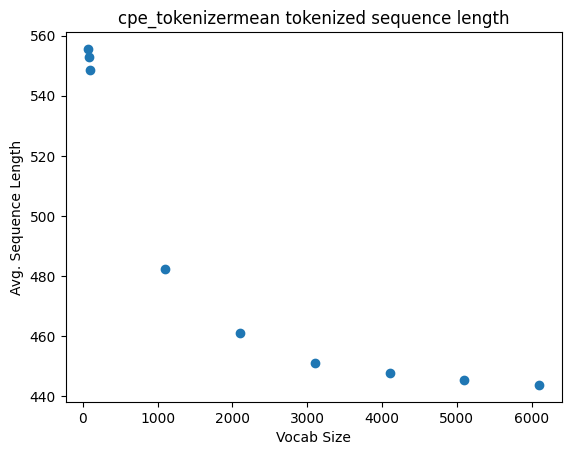

In [16]:
# CPE: [64, 80, 100, 200, 300, 400, ... , 3000]
cpe_vocab_sizes = [71, 80]
cpe_vocab_sizes.extend(iter(range(100, max_vocab_all + 1, 1000)))

plot_mean_seq_lens(
    dna_sequences=val_samples, 
    vocab_sizes=cpe_vocab_sizes,
    bpe_tokenizer_type="cpe_tokenizer",
    #save_tokenizer = True, 
    save_plot_data = True
)

In [45]:
seq_lens = [len(seq.sequence) for seq in val_samples if len(seq.sequence) < 40000 and len(seq.sequence) > 1000]

In [46]:
len(seq_lens)

5331

In [47]:
import numpy as np
data = np.array(seq_lens)
import matplotlib.pyplot as plt

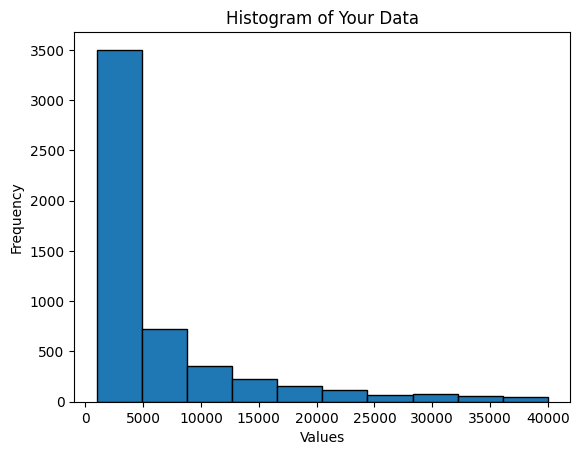

In [48]:
plt.hist(data, edgecolor='black')

# Add labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of Your Data')

# Show the plot
plt.show()

In [32]:
data.shape

(9351,)

In [34]:
import pandas as pd

df = pd.DataFrame(data)

In [35]:
df

,0
0,117
1,222690
2,10971
3,684
4,876
...,...
15812,2214
15813,111
15814,10860
15815,750


NameError: name 'plt' is not defined

Training tokenizer



Returning tokenizer with vocab_size = 28
Finding lens for 28


100%|██████████| 36631/36631 [00:01<00:00, 20349.36it/s]


Training tokenizer



Returning tokenizer with vocab_size = 40
Finding lens for 40


100%|██████████| 36631/36631 [00:01<00:00, 19808.45it/s]


Training tokenizer



Returning tokenizer with vocab_size = 60
Finding lens for 60


100%|██████████| 36631/36631 [00:01<00:00, 19397.02it/s]


Training tokenizer



Returning tokenizer with vocab_size = 80
Finding lens for 80


100%|██████████| 36631/36631 [00:01<00:00, 21517.95it/s]


Training tokenizer



Returning tokenizer with vocab_size = 100
Finding lens for 100


100%|██████████| 36631/36631 [00:01<00:00, 22130.53it/s]


Training tokenizer



Returning tokenizer with vocab_size = 200
Finding lens for 200


100%|██████████| 36631/36631 [00:01<00:00, 22270.33it/s]


Training tokenizer



Returning tokenizer with vocab_size = 300
Finding lens for 300


100%|██████████| 36631/36631 [00:01<00:00, 23502.96it/s]


Training tokenizer



Returning tokenizer with vocab_size = 400
Finding lens for 400


100%|██████████| 36631/36631 [00:01<00:00, 23735.04it/s]


Training tokenizer



Returning tokenizer with vocab_size = 500
Finding lens for 500


100%|██████████| 36631/36631 [00:01<00:00, 23737.03it/s]


Training tokenizer



Returning tokenizer with vocab_size = 600
Finding lens for 600


100%|██████████| 36631/36631 [00:01<00:00, 22429.80it/s]


Training tokenizer



Returning tokenizer with vocab_size = 700
Finding lens for 700


100%|██████████| 36631/36631 [00:01<00:00, 24321.91it/s]


Training tokenizer



Returning tokenizer with vocab_size = 800
Finding lens for 800


100%|██████████| 36631/36631 [00:01<00:00, 24562.01it/s]


Training tokenizer



Returning tokenizer with vocab_size = 900
Finding lens for 900


100%|██████████| 36631/36631 [00:01<00:00, 23784.41it/s]


Training tokenizer



Returning tokenizer with vocab_size = 1000
Finding lens for 1000


100%|██████████| 36631/36631 [00:01<00:00, 24269.62it/s]


Training tokenizer



Returning tokenizer with vocab_size = 1100
Finding lens for 1100


100%|██████████| 36631/36631 [00:01<00:00, 24612.06it/s]


Training tokenizer



Returning tokenizer with vocab_size = 1200
Finding lens for 1200


100%|██████████| 36631/36631 [00:01<00:00, 24472.04it/s]


Training tokenizer



Returning tokenizer with vocab_size = 1300
Finding lens for 1300


100%|██████████| 36631/36631 [00:01<00:00, 24533.44it/s]


Training tokenizer



Returning tokenizer with vocab_size = 1400
Finding lens for 1400


100%|██████████| 36631/36631 [00:01<00:00, 24853.55it/s]


Training tokenizer



Returning tokenizer with vocab_size = 1500
Finding lens for 1500


100%|██████████| 36631/36631 [00:01<00:00, 24151.73it/s]


Training tokenizer



Returning tokenizer with vocab_size = 1600
Finding lens for 1600


100%|██████████| 36631/36631 [00:01<00:00, 25025.58it/s]


Training tokenizer



Returning tokenizer with vocab_size = 1700
Finding lens for 1700


100%|██████████| 36631/36631 [00:01<00:00, 24070.60it/s]


Training tokenizer



Returning tokenizer with vocab_size = 1800
Finding lens for 1800


100%|██████████| 36631/36631 [00:01<00:00, 24604.48it/s]


Training tokenizer



Returning tokenizer with vocab_size = 1900
Finding lens for 1900


100%|██████████| 36631/36631 [00:01<00:00, 25023.41it/s]


Training tokenizer



Returning tokenizer with vocab_size = 2000
Finding lens for 2000


100%|██████████| 36631/36631 [00:01<00:00, 24435.37it/s]


Training tokenizer



Returning tokenizer with vocab_size = 2100
Finding lens for 2100


100%|██████████| 36631/36631 [00:01<00:00, 24090.91it/s]


Training tokenizer



Returning tokenizer with vocab_size = 2200
Finding lens for 2200


100%|██████████| 36631/36631 [00:01<00:00, 24416.95it/s]


Training tokenizer



Returning tokenizer with vocab_size = 2300
Finding lens for 2300


100%|██████████| 36631/36631 [00:01<00:00, 24860.89it/s]


Training tokenizer



Returning tokenizer with vocab_size = 2400
Finding lens for 2400


100%|██████████| 36631/36631 [00:01<00:00, 24221.02it/s]


Training tokenizer



Returning tokenizer with vocab_size = 2500
Finding lens for 2500


100%|██████████| 36631/36631 [00:01<00:00, 24562.24it/s]


Training tokenizer



Returning tokenizer with vocab_size = 2600
Finding lens for 2600


100%|██████████| 36631/36631 [00:01<00:00, 24336.95it/s]


Training tokenizer



Returning tokenizer with vocab_size = 2700
Finding lens for 2700


100%|██████████| 36631/36631 [00:01<00:00, 25244.82it/s]


Training tokenizer



Returning tokenizer with vocab_size = 2800
Finding lens for 2800


100%|██████████| 36631/36631 [00:01<00:00, 24992.39it/s]


Training tokenizer



Returning tokenizer with vocab_size = 2900
Finding lens for 2900


100%|██████████| 36631/36631 [00:01<00:00, 24398.40it/s]


Training tokenizer



Returning tokenizer with vocab_size = 3000
Finding lens for 3000


100%|██████████| 36631/36631 [00:01<00:00, 22114.20it/s]


Training tokenizer



Returning tokenizer with vocab_size = 3100
Finding lens for 3100


100%|██████████| 36631/36631 [00:01<00:00, 24035.18it/s]


Training tokenizer



Returning tokenizer with vocab_size = 3200
Finding lens for 3200


100%|██████████| 36631/36631 [00:01<00:00, 25066.07it/s]


Training tokenizer



Returning tokenizer with vocab_size = 3300
Finding lens for 3300


100%|██████████| 36631/36631 [00:01<00:00, 24797.99it/s]


Training tokenizer



Returning tokenizer with vocab_size = 3400
Finding lens for 3400


100%|██████████| 36631/36631 [00:01<00:00, 24909.15it/s]


Training tokenizer



Returning tokenizer with vocab_size = 3500
Finding lens for 3500


100%|██████████| 36631/36631 [00:01<00:00, 25351.98it/s]


Training tokenizer



Returning tokenizer with vocab_size = 3600
Finding lens for 3600


100%|██████████| 36631/36631 [00:01<00:00, 24750.87it/s]


Training tokenizer



Returning tokenizer with vocab_size = 3700
Finding lens for 3700


100%|██████████| 36631/36631 [00:01<00:00, 23977.60it/s]


Training tokenizer



Returning tokenizer with vocab_size = 3800
Finding lens for 3800


100%|██████████| 36631/36631 [00:01<00:00, 24302.57it/s]


Training tokenizer



Returning tokenizer with vocab_size = 3900
Finding lens for 3900


100%|██████████| 36631/36631 [00:01<00:00, 24309.90it/s]


Training tokenizer



Returning tokenizer with vocab_size = 4000
Finding lens for 4000


100%|██████████| 36631/36631 [00:01<00:00, 25406.91it/s]


Training tokenizer



Returning tokenizer with vocab_size = 4100
Finding lens for 4100


100%|██████████| 36631/36631 [00:01<00:00, 24583.25it/s]


Training tokenizer



Returning tokenizer with vocab_size = 4200
Finding lens for 4200


100%|██████████| 36631/36631 [00:01<00:00, 23691.06it/s]


Training tokenizer



Returning tokenizer with vocab_size = 4300
Finding lens for 4300


100%|██████████| 36631/36631 [00:01<00:00, 24810.16it/s]


Training tokenizer



Returning tokenizer with vocab_size = 4400
Finding lens for 4400


100%|██████████| 36631/36631 [00:01<00:00, 24382.23it/s]


Training tokenizer



Returning tokenizer with vocab_size = 4500
Finding lens for 4500


100%|██████████| 36631/36631 [00:01<00:00, 24793.08it/s]


Training tokenizer



Returning tokenizer with vocab_size = 4600
Finding lens for 4600


100%|██████████| 36631/36631 [00:01<00:00, 23708.53it/s]


Training tokenizer



Returning tokenizer with vocab_size = 4700
Finding lens for 4700


100%|██████████| 36631/36631 [00:01<00:00, 25134.92it/s]


Training tokenizer



Returning tokenizer with vocab_size = 4800
Finding lens for 4800


100%|██████████| 36631/36631 [00:01<00:00, 24830.73it/s]


Training tokenizer



Returning tokenizer with vocab_size = 4900
Finding lens for 4900


100%|██████████| 36631/36631 [00:01<00:00, 24642.23it/s]


Training tokenizer



Returning tokenizer with vocab_size = 5000
Finding lens for 5000


100%|██████████| 36631/36631 [00:01<00:00, 25219.32it/s]


Training tokenizer



Returning tokenizer with vocab_size = 5100
Finding lens for 5100


100%|██████████| 36631/36631 [00:01<00:00, 25151.04it/s]


Training tokenizer



Returning tokenizer with vocab_size = 5200
Finding lens for 5200


100%|██████████| 36631/36631 [00:01<00:00, 23971.42it/s]


Training tokenizer



Returning tokenizer with vocab_size = 5300
Finding lens for 5300


100%|██████████| 36631/36631 [00:01<00:00, 24919.59it/s]


Training tokenizer



Returning tokenizer with vocab_size = 5400
Finding lens for 5400


100%|██████████| 36631/36631 [00:01<00:00, 25333.96it/s]


Training tokenizer



Returning tokenizer with vocab_size = 5500
Finding lens for 5500


100%|██████████| 36631/36631 [00:01<00:00, 25050.68it/s]


Training tokenizer



Returning tokenizer with vocab_size = 5600
Finding lens for 5600


100%|██████████| 36631/36631 [00:01<00:00, 24620.21it/s]


Training tokenizer



Returning tokenizer with vocab_size = 5700
Finding lens for 5700


100%|██████████| 36631/36631 [00:01<00:00, 25060.50it/s]


Training tokenizer



Returning tokenizer with vocab_size = 5800
Finding lens for 5800


100%|██████████| 36631/36631 [00:01<00:00, 25002.90it/s]


Training tokenizer



Returning tokenizer with vocab_size = 5900
Finding lens for 5900


100%|██████████| 36631/36631 [00:01<00:00, 24421.38it/s]


Training tokenizer



Returning tokenizer with vocab_size = 6000
Finding lens for 6000


100%|██████████| 36631/36631 [00:01<00:00, 23828.86it/s]


Training tokenizer



Returning tokenizer with vocab_size = 6100
Finding lens for 6100


100%|██████████| 36631/36631 [00:01<00:00, 25082.22it/s]


Training tokenizer



Returning tokenizer with vocab_size = 6200
Finding lens for 6200


100%|██████████| 36631/36631 [00:01<00:00, 24707.01it/s]


Training tokenizer



Returning tokenizer with vocab_size = 6300
Finding lens for 6300


100%|██████████| 36631/36631 [00:01<00:00, 24492.96it/s]


Training tokenizer



Returning tokenizer with vocab_size = 6400
Finding lens for 6400


100%|██████████| 36631/36631 [00:01<00:00, 24612.32it/s]


Training tokenizer



Returning tokenizer with vocab_size = 6500
Finding lens for 6500


100%|██████████| 36631/36631 [00:01<00:00, 24584.96it/s]


Training tokenizer



Returning tokenizer with vocab_size = 6600
Finding lens for 6600


100%|██████████| 36631/36631 [00:01<00:00, 24728.66it/s]


Training tokenizer



Returning tokenizer with vocab_size = 6700
Finding lens for 6700


100%|██████████| 36631/36631 [00:01<00:00, 25020.14it/s]


Training tokenizer



Returning tokenizer with vocab_size = 6800
Finding lens for 6800


100%|██████████| 36631/36631 [00:01<00:00, 25612.21it/s]


Training tokenizer



Returning tokenizer with vocab_size = 6900
Finding lens for 6900


100%|██████████| 36631/36631 [00:01<00:00, 24757.54it/s]


Training tokenizer



Returning tokenizer with vocab_size = 7000
Finding lens for 7000


100%|██████████| 36631/36631 [00:01<00:00, 25362.46it/s]


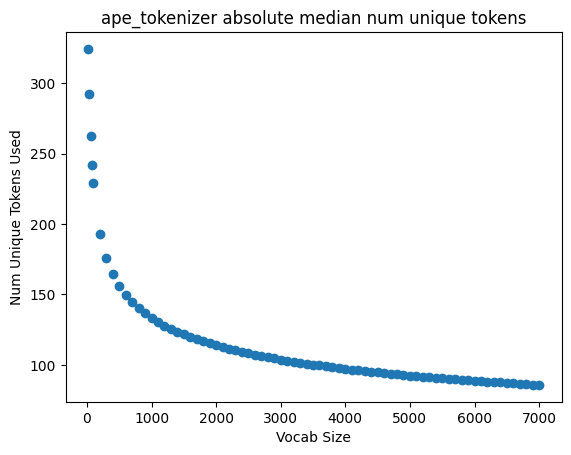

In [32]:
# APE: [20, 40, 60, 80, 100, 200, 300, 400, ... , 3000]

ape_vocab_sizes = [20, 40, 60, 80]
ape_vocab_sizes.extend(iter(range(100, max_vocab_all + 1, 100)))

plot_mean_seq_lens(
    sequence_fasta_file="/home/couchbucks/Documents/saketh/cpe/data/datasets/mdh_natural_dataset.fasta", 
    vocab_sizes=ape_vocab_sizes,
    bpe_tokenizer_type="ape_tokenizer",
    #save_tokenizer = True, 
    save_plot_data = True
)

Training tokenizer



Returning tokenizer with vocab_size = 11
Finding lens for 11


100%|██████████| 36631/36631 [00:02<00:00, 15323.72it/s]


Training tokenizer



Returning tokenizer with vocab_size = 11
Finding lens for 11


100%|██████████| 36631/36631 [00:02<00:00, 14818.21it/s]


Training tokenizer



Returning tokenizer with vocab_size = 12
Finding lens for 12


100%|██████████| 36631/36631 [00:02<00:00, 16211.76it/s]


Training tokenizer



Returning tokenizer with vocab_size = 16
Finding lens for 16


100%|██████████| 36631/36631 [00:02<00:00, 16844.79it/s]


Training tokenizer



Returning tokenizer with vocab_size = 20
Finding lens for 20


100%|██████████| 36631/36631 [00:01<00:00, 18381.41it/s]


Training tokenizer



Returning tokenizer with vocab_size = 40
Finding lens for 40


100%|██████████| 36631/36631 [00:02<00:00, 17854.23it/s]


Training tokenizer



Returning tokenizer with vocab_size = 60
Finding lens for 60


100%|██████████| 36631/36631 [00:01<00:00, 19646.48it/s]


Training tokenizer



Returning tokenizer with vocab_size = 80
Finding lens for 80


100%|██████████| 36631/36631 [00:01<00:00, 19905.11it/s]


Training tokenizer



Returning tokenizer with vocab_size = 100
Finding lens for 100


100%|██████████| 36631/36631 [00:01<00:00, 18410.15it/s]


Training tokenizer



Returning tokenizer with vocab_size = 200
Finding lens for 200


100%|██████████| 36631/36631 [00:01<00:00, 20505.57it/s]


Training tokenizer



Returning tokenizer with vocab_size = 300
Finding lens for 300


100%|██████████| 36631/36631 [00:01<00:00, 19987.92it/s]


Training tokenizer



Returning tokenizer with vocab_size = 400
Finding lens for 400


100%|██████████| 36631/36631 [00:01<00:00, 19649.18it/s]


Training tokenizer



Returning tokenizer with vocab_size = 500
Finding lens for 500


100%|██████████| 36631/36631 [00:01<00:00, 22458.31it/s]


Training tokenizer



Returning tokenizer with vocab_size = 600
Finding lens for 600


100%|██████████| 36631/36631 [00:01<00:00, 22273.31it/s]


Training tokenizer



Returning tokenizer with vocab_size = 700
Finding lens for 700


100%|██████████| 36631/36631 [00:01<00:00, 22570.70it/s]


Training tokenizer



Returning tokenizer with vocab_size = 800
Finding lens for 800


100%|██████████| 36631/36631 [00:01<00:00, 23141.49it/s]


Training tokenizer



Returning tokenizer with vocab_size = 900
Finding lens for 900


100%|██████████| 36631/36631 [00:01<00:00, 23376.87it/s]


Training tokenizer



Returning tokenizer with vocab_size = 1000
Finding lens for 1000


100%|██████████| 36631/36631 [00:01<00:00, 22301.03it/s]


Training tokenizer



Returning tokenizer with vocab_size = 1100
Finding lens for 1100


100%|██████████| 36631/36631 [00:01<00:00, 22182.96it/s]


Training tokenizer



Returning tokenizer with vocab_size = 1200
Finding lens for 1200


100%|██████████| 36631/36631 [00:01<00:00, 22831.99it/s]


Training tokenizer



Returning tokenizer with vocab_size = 1300
Finding lens for 1300


100%|██████████| 36631/36631 [00:01<00:00, 22932.08it/s]


Training tokenizer



Returning tokenizer with vocab_size = 1400
Finding lens for 1400


100%|██████████| 36631/36631 [00:01<00:00, 22127.04it/s]


Training tokenizer



Returning tokenizer with vocab_size = 1500
Finding lens for 1500


100%|██████████| 36631/36631 [00:01<00:00, 22296.19it/s]


Training tokenizer



Returning tokenizer with vocab_size = 1600
Finding lens for 1600


100%|██████████| 36631/36631 [00:01<00:00, 23294.59it/s]


Training tokenizer



Returning tokenizer with vocab_size = 1700
Finding lens for 1700


100%|██████████| 36631/36631 [00:01<00:00, 22503.75it/s]


Training tokenizer



Returning tokenizer with vocab_size = 1800
Finding lens for 1800


100%|██████████| 36631/36631 [00:01<00:00, 23160.62it/s]


Training tokenizer



Returning tokenizer with vocab_size = 1900
Finding lens for 1900


100%|██████████| 36631/36631 [00:01<00:00, 23390.85it/s]


Training tokenizer



Returning tokenizer with vocab_size = 2000
Finding lens for 2000


100%|██████████| 36631/36631 [00:01<00:00, 21530.65it/s]


Training tokenizer



Returning tokenizer with vocab_size = 2100
Finding lens for 2100


100%|██████████| 36631/36631 [00:01<00:00, 22828.73it/s]


Training tokenizer



Returning tokenizer with vocab_size = 2200
Finding lens for 2200


100%|██████████| 36631/36631 [00:01<00:00, 22913.64it/s]


Training tokenizer



Returning tokenizer with vocab_size = 2300
Finding lens for 2300


100%|██████████| 36631/36631 [00:01<00:00, 22021.92it/s]


Training tokenizer



Returning tokenizer with vocab_size = 2400
Finding lens for 2400


100%|██████████| 36631/36631 [00:01<00:00, 22737.13it/s]


Training tokenizer



Returning tokenizer with vocab_size = 2500
Finding lens for 2500


100%|██████████| 36631/36631 [00:01<00:00, 22955.62it/s]


Training tokenizer



Returning tokenizer with vocab_size = 2600
Finding lens for 2600


100%|██████████| 36631/36631 [00:01<00:00, 23309.64it/s]


Training tokenizer



Returning tokenizer with vocab_size = 2700
Finding lens for 2700


100%|██████████| 36631/36631 [00:01<00:00, 23576.33it/s]


Training tokenizer



Returning tokenizer with vocab_size = 2800
Finding lens for 2800


100%|██████████| 36631/36631 [00:01<00:00, 23655.51it/s]


Training tokenizer



Returning tokenizer with vocab_size = 2900
Finding lens for 2900


100%|██████████| 36631/36631 [00:01<00:00, 22886.72it/s]


Training tokenizer



Returning tokenizer with vocab_size = 3000
Finding lens for 3000


100%|██████████| 36631/36631 [00:01<00:00, 23376.00it/s]


Training tokenizer



Returning tokenizer with vocab_size = 3100
Finding lens for 3100


100%|██████████| 36631/36631 [00:01<00:00, 22828.73it/s]


Training tokenizer



Returning tokenizer with vocab_size = 3200
Finding lens for 3200


100%|██████████| 36631/36631 [00:01<00:00, 22946.64it/s]


Training tokenizer



Returning tokenizer with vocab_size = 3300
Finding lens for 3300


100%|██████████| 36631/36631 [00:01<00:00, 23532.65it/s]


Training tokenizer



Returning tokenizer with vocab_size = 3400
Finding lens for 3400


100%|██████████| 36631/36631 [00:01<00:00, 22528.41it/s]


Training tokenizer



Returning tokenizer with vocab_size = 3500
Finding lens for 3500


100%|██████████| 36631/36631 [00:01<00:00, 23007.48it/s]


Training tokenizer



Returning tokenizer with vocab_size = 3600
Finding lens for 3600


100%|██████████| 36631/36631 [00:01<00:00, 22962.37it/s]


Training tokenizer



Returning tokenizer with vocab_size = 3700
Finding lens for 3700


100%|██████████| 36631/36631 [00:01<00:00, 23046.60it/s]


Training tokenizer



Returning tokenizer with vocab_size = 3800
Finding lens for 3800


100%|██████████| 36631/36631 [00:01<00:00, 23448.89it/s]


Training tokenizer



Returning tokenizer with vocab_size = 3900
Finding lens for 3900


100%|██████████| 36631/36631 [00:01<00:00, 23409.45it/s]


Training tokenizer



Returning tokenizer with vocab_size = 4000
Finding lens for 4000


100%|██████████| 36631/36631 [00:01<00:00, 23706.04it/s]


Training tokenizer



Returning tokenizer with vocab_size = 4100
Finding lens for 4100


100%|██████████| 36631/36631 [00:01<00:00, 22892.05it/s]


Training tokenizer



Returning tokenizer with vocab_size = 4200
Finding lens for 4200


100%|██████████| 36631/36631 [00:01<00:00, 23630.62it/s]


Training tokenizer



Returning tokenizer with vocab_size = 4300
Finding lens for 4300


100%|██████████| 36631/36631 [00:01<00:00, 23163.48it/s]


Training tokenizer



Returning tokenizer with vocab_size = 4400
Finding lens for 4400


100%|██████████| 36631/36631 [00:01<00:00, 23332.63it/s]


Training tokenizer



Returning tokenizer with vocab_size = 4500
Finding lens for 4500


100%|██████████| 36631/36631 [00:01<00:00, 23810.94it/s]


Training tokenizer



Returning tokenizer with vocab_size = 4600
Finding lens for 4600


100%|██████████| 36631/36631 [00:01<00:00, 23860.48it/s]


Training tokenizer



Returning tokenizer with vocab_size = 4700
Finding lens for 4700


100%|██████████| 36631/36631 [00:01<00:00, 23534.14it/s]


Training tokenizer



Returning tokenizer with vocab_size = 4800
Finding lens for 4800


100%|██████████| 36631/36631 [00:01<00:00, 23455.53it/s]


Training tokenizer



Returning tokenizer with vocab_size = 4900
Finding lens for 4900


100%|██████████| 36631/36631 [00:01<00:00, 22810.39it/s]


Training tokenizer



Returning tokenizer with vocab_size = 5000
Finding lens for 5000


100%|██████████| 36631/36631 [00:01<00:00, 23693.27it/s]


Training tokenizer



Returning tokenizer with vocab_size = 5100
Finding lens for 5100


100%|██████████| 36631/36631 [00:01<00:00, 23240.09it/s]


Training tokenizer



Returning tokenizer with vocab_size = 5200
Finding lens for 5200


100%|██████████| 36631/36631 [00:01<00:00, 23489.13it/s]


Training tokenizer



Returning tokenizer with vocab_size = 5300
Finding lens for 5300


100%|██████████| 36631/36631 [00:01<00:00, 23376.47it/s]


Training tokenizer



Returning tokenizer with vocab_size = 5400
Finding lens for 5400


100%|██████████| 36631/36631 [00:01<00:00, 23719.97it/s]


Training tokenizer



Returning tokenizer with vocab_size = 5500
Finding lens for 5500


100%|██████████| 36631/36631 [00:01<00:00, 23493.04it/s]


Training tokenizer



Returning tokenizer with vocab_size = 5600
Finding lens for 5600


100%|██████████| 36631/36631 [00:01<00:00, 23350.32it/s]


Training tokenizer



Returning tokenizer with vocab_size = 5700
Finding lens for 5700


100%|██████████| 36631/36631 [00:01<00:00, 23408.16it/s]


Training tokenizer



Returning tokenizer with vocab_size = 5800
Finding lens for 5800


100%|██████████| 36631/36631 [00:01<00:00, 23636.32it/s]


Training tokenizer



Returning tokenizer with vocab_size = 5900
Finding lens for 5900


100%|██████████| 36631/36631 [00:01<00:00, 23434.53it/s]


Training tokenizer



Returning tokenizer with vocab_size = 6000
Finding lens for 6000


100%|██████████| 36631/36631 [00:01<00:00, 23122.75it/s]


Training tokenizer



Returning tokenizer with vocab_size = 6100
Finding lens for 6100


100%|██████████| 36631/36631 [00:01<00:00, 23624.67it/s]


Training tokenizer



Returning tokenizer with vocab_size = 6200
Finding lens for 6200


100%|██████████| 36631/36631 [00:01<00:00, 23447.35it/s]


Training tokenizer



Returning tokenizer with vocab_size = 6300
Finding lens for 6300


100%|██████████| 36631/36631 [00:01<00:00, 23247.32it/s]


Training tokenizer



Returning tokenizer with vocab_size = 6400
Finding lens for 6400


100%|██████████| 36631/36631 [00:01<00:00, 23697.24it/s]


Training tokenizer



Returning tokenizer with vocab_size = 6500
Finding lens for 6500


100%|██████████| 36631/36631 [00:01<00:00, 23919.16it/s]


Training tokenizer



Returning tokenizer with vocab_size = 6600
Finding lens for 6600


100%|██████████| 36631/36631 [00:01<00:00, 23201.98it/s]


Training tokenizer



Returning tokenizer with vocab_size = 6700
Finding lens for 6700


100%|██████████| 36631/36631 [00:01<00:00, 23835.42it/s]


Training tokenizer



Returning tokenizer with vocab_size = 6800
Finding lens for 6800


100%|██████████| 36631/36631 [00:01<00:00, 23847.63it/s]


Training tokenizer



Returning tokenizer with vocab_size = 6900
Finding lens for 6900


100%|██████████| 36631/36631 [00:01<00:00, 23416.57it/s]


Training tokenizer



Returning tokenizer with vocab_size = 7000
Finding lens for 7000


100%|██████████| 36631/36631 [00:01<00:00, 23224.76it/s]


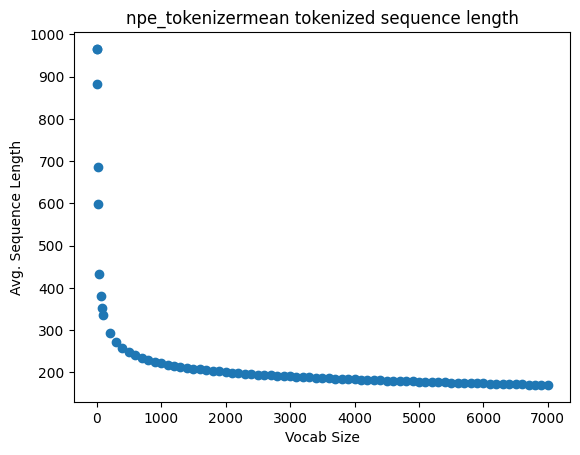

In [35]:
# NPE: [4, 8, 12, 16, 20, 40, 60, 80, 100, 200, 300, 400, ... , 3000]

npe_vocab_sizes = [4, 8, 12, 16, 20, 40, 60, 80]
npe_vocab_sizes.extend(iter(range(100, max_vocab_all + 1, 100)))

plot_mean_seq_lens(
    sequence_fasta_file="/home/couchbucks/Documents/saketh/cpe/data/datasets/mdh_natural_dataset.fasta", 
    vocab_sizes=npe_vocab_sizes,
    bpe_tokenizer_type="npe_tokenizer",
    #save_tokenizer = True, 
    save_plot_data = True
)

Proper vocab sizes:
1. CPE: 1500
2. APE: 400
3. NPE: 

In [ ]:
"""

CPE:
num_tokens_in_vocab = {100: 64, 200: 85, 300: 97, 400: 106, 500: 112, 600: 117, 700: 121, 800: 124, 900: 127, 1000: 129, 1100: 131, 1200: 133, 1300: 134, 1400: 135, 1500: 136, 1600: 136, 1700: 137, 1800: 138, 1900: 138, 2000: 138, 2100: 139, 2200: 139, 2300: 139, 2400: 139, 2500: 139, 2600: 139, 2700: 139, 2800: 140, 2900: 140}
per_vocab_in_vocab = {100: 0.64, 200: 0.425, 300: 0.3233333333333333, 400: 0.265, 500: 0.224, 600: 0.195, 700: 0.17285714285714285, 800: 0.155, 900: 0.1411111111111111, 1000: 0.129, 1100: 0.1190909090909091, 1200: 0.11083333333333334, 1300: 0.10307692307692308, 1400: 0.09642857142857143, 1500: 0.09066666666666667, 1600: 0.085, 1700: 0.08058823529411764, 1800: 0.07666666666666666, 1900: 0.07263157894736842, 2000: 0.069, 2100: 0.06619047619047619, 2200: 0.06318181818181819, 2300: 0.06043478260869565, 2400: 0.057916666666666665, 2500: 0.0556, 2600: 0.05346153846153846, 2700: 0.05148148148148148, 2800: 0.05, 2900: 0.04827586206896552}

APE: 
num_tokens_in_vocab = {20: 24, 120: 82, 220: 101, 320: 107, 420: 109, 520: 109, 620: 110, 720: 109, 820: 109, 920: 108, 1020: 107, 1120: 107, 1220: 106, 1320: 105, 1420: 105, 1520: 104, 1620: 104, 1720: 103, 1820: 102, 1920: 101}
per_vocab_in_vocab = {20: 0.8571428571428571, 120: 0.6833333333333333, 220: 0.4590909090909091, 320: 0.334375, 420: 0.25952380952380955, 520: 0.20961538461538462, 620: 0.1774193548387097, 720: 0.15138888888888888, 820: 0.1329268292682927, 920: 0.11739130434782609, 1020: 0.10490196078431373, 1120: 0.09553571428571428, 1220: 0.08688524590163935, 1320: 0.07954545454545454, 1420: 0.07394366197183098, 1520: 0.06842105263157895, 1620: 0.06419753086419754, 1720: 0.05988372093023256, 1820: 0.056043956043956046, 1920: 0.05260416666666667}

NPE: 
num_tokens_in_vocab = {1000: 152, 1250: 154, 1500: 156, 1750: 157, 2000: 157, 2250: 158, 2500: 158, 2750: 158, 3000: 158, 3250: 158, 3500: 158, 3750: 158, 4000: 158, 4250: 158, 4500: 158, 4750: 157}
per_vocab_in_vocab = {1000: 0.152, 1250: 0.1232, 1500: 0.104, 1750: 0.08971428571428572, 2000: 0.0785, 2250: 0.07022222222222223, 2500: 0.0632, 2750: 0.05745454545454545, 3000: 0.05266666666666667, 3250: 0.048615384615384616, 3500: 0.045142857142857144, 3750: 0.042133333333333335, 4000: 0.0395, 4250: 0.0371764705882353, 4500: 0.035111111111111114, 4750: 0.03305263157894737}

"""

'\n\nCPE:\nnum_tokens_in_vocab = {100: 64, 200: 85, 300: 97, 400: 106, 500: 112, 600: 117, 700: 121, 800: 124, 900: 127, 1000: 129, 1100: 131, 1200: 133, 1300: 134, 1400: 135, 1500: 136, 1600: 136, 1700: 137, 1800: 138, 1900: 138, 2000: 138, 2100: 139, 2200: 139, 2300: 139, 2400: 139, 2500: 139, 2600: 139, 2700: 139, 2800: 140, 2900: 140}\nper_vocab_in_vocab = {100: 0.64, 200: 0.425, 300: 0.3233333333333333, 400: 0.265, 500: 0.224, 600: 0.195, 700: 0.17285714285714285, 800: 0.155, 900: 0.1411111111111111, 1000: 0.129, 1100: 0.1190909090909091, 1200: 0.11083333333333334, 1300: 0.10307692307692308, 1400: 0.09642857142857143, 1500: 0.09066666666666667, 1600: 0.085, 1700: 0.08058823529411764, 1800: 0.07666666666666666, 1900: 0.07263157894736842, 2000: 0.069, 2100: 0.06619047619047619, 2200: 0.06318181818181819, 2300: 0.06043478260869565, 2400: 0.057916666666666665, 2500: 0.0556, 2600: 0.05346153846153846, 2700: 0.05148148148148148, 2800: 0.05, 2900: 0.04827586206896552}\n\nAPE: \nnum_token

In [ ]:
num_tokens_in_vocab = {
    100: 64,
    200: 85,
    300: 97,
    400: 106,
    500: 112,
    600: 117,
    700: 121,
    800: 124,
    900: 127,
    1000: 129,
    1100: 131,
    1200: 133,
    1300: 134,
    1400: 135,
    1500: 136,
    1600: 136,
    1700: 137,
    1800: 138,
    1900: 138,
    2000: 138,
    2100: 139,
    2200: 139,
    2300: 139,
    2400: 139,
    2500: 139,
    2600: 139,
    2700: 139,
    2800: 140,
    2900: 140,
}
per_vocab_in_vocab = {
    100: 0.64,
    200: 0.425,
    300: 0.3233333333333333,
    400: 0.265,
    500: 0.224,
    600: 0.195,
    700: 0.17285714285714285,
    800: 0.155,
    900: 0.1411111111111111,
    1000: 0.129,
    1100: 0.1190909090909091,
    1200: 0.11083333333333334,
    1300: 0.10307692307692308,
    1400: 0.09642857142857143,
    1500: 0.09066666666666667,
    1600: 0.085,
    1700: 0.08058823529411764,
    1800: 0.07666666666666666,
    1900: 0.07263157894736842,
    2000: 0.069,
    2100: 0.06619047619047619,
    2200: 0.06318181818181819,
    2300: 0.06043478260869565,
    2400: 0.057916666666666665,
    2500: 0.0556,
    2600: 0.05346153846153846,
    2700: 0.05148148148148148,
    2800: 0.05,
    2900: 0.04827586206896552,
}

data = []

for vocab_size, per_tokens in per_vocab_in_vocab.items():
    abs_tokens = num_tokens_in_vocab[vocab_size]
    data.append(
        {
            "vocab_size": vocab_size,
            "median_tokens": abs_tokens,
            "relative_tokens": per_tokens,
        }
    )

print(data)

[{'vocab_size': 100, 'median_tokens': 64, 'relative_tokens': 0.64}, {'vocab_size': 200, 'median_tokens': 85, 'relative_tokens': 0.425}, {'vocab_size': 300, 'median_tokens': 97, 'relative_tokens': 0.3233333333333333}, {'vocab_size': 400, 'median_tokens': 106, 'relative_tokens': 0.265}, {'vocab_size': 500, 'median_tokens': 112, 'relative_tokens': 0.224}, {'vocab_size': 600, 'median_tokens': 117, 'relative_tokens': 0.195}, {'vocab_size': 700, 'median_tokens': 121, 'relative_tokens': 0.17285714285714285}, {'vocab_size': 800, 'median_tokens': 124, 'relative_tokens': 0.155}, {'vocab_size': 900, 'median_tokens': 127, 'relative_tokens': 0.1411111111111111}, {'vocab_size': 1000, 'median_tokens': 129, 'relative_tokens': 0.129}, {'vocab_size': 1100, 'median_tokens': 131, 'relative_tokens': 0.1190909090909091}, {'vocab_size': 1200, 'median_tokens': 133, 'relative_tokens': 0.11083333333333334}, {'vocab_size': 1300, 'median_tokens': 134, 'relative_tokens': 0.10307692307692308}, {'vocab_size': 1400, 